



1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process



In [2]:
#code to create frames for .mp4 file



In [ ]:
import cv2

# Path to the video file
video_path = '1.mp4'

# Open the video file
video = cv2.VideoCapture(video_path)

# Read and save frames
success, frame = video.read()
count = 0

while success:
    # Save the frame as an image file
    cv2.imwrite(f'frame_{count}.jpg', frame)
    
    # Read the next frame
    success, frame = video.read()
    
    count += 1

# Release the video file
video.release()


In [ ]:
##CODE TO EXTRACT FACES FROM 1.MP4 VIDEOs

In [ ]:
import dlib
import cv2

# Load the face detector and shape predictor
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Open the video file
video_path = '1.mp4'
cap = cv2.VideoCapture(video_path)

# Initialize counter for image filenames
image_counter = 1

# Loop through each frame in the video
while cap.isOpened():
    # Read the current frame
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to HSV for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection on the grayscale frame
    faces = face_detector(gray)

    # Extract and save the faces
    for face in faces:
        landmarks = shape_predictor(gray, face)
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_region = frame[y:y+h, x:x+w]
        cv2.imwrite('folder/{}.jpg'.format(image_counter), face_region)
        image_counter += 1

    # Display the frame with detected faces
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [24]:
"""
TESTED DATASETS

CNN 
1.YOU SHARED->FINE
2.YOU SHARED VIDEO 1>FAILED
3.YOU SHARED VIDEO 2->PASSED

2.VGG->TRAINING->TESTING->FAILED
1.YOU SHARED->FINE
2.YOU SHARED VIDEO 1>FAILED
3.YOU SHARED VIDEO 2->PASSED


"""


'\nTESTED DATASETS\n\nCNN \n1.YOU SHARED->FINE\n2.YOU SHARED VIDEO 1>FAILED\n3.YOU SHARED VIDEO 2->PASSED\n\n2.VGG->TRAINING->TESTING->FAILED\n1.YOU SHARED->FINE\n2.YOU SHARED VIDEO 1>FAILED\n3.YOU SHARED VIDEO 2->PASSED\n\n\n'

## Setup



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path(r'D:\\UNBC_DATASET\\HSV')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2644


Here are some roses:

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2644 files belonging to 3 classes.
Using 2116 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2644 files belonging to 3 classes.
Using 528 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [30]:
class_names = train_ds.class_names
print(class_names)

NameError: name 'train_ds' is not defined

## Visualize the data

Here are the first nine images from the training dataset:

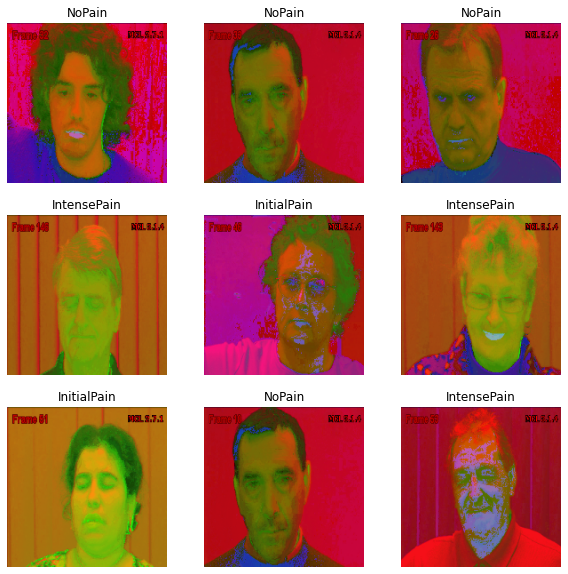

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [12]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [18]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
67/67 [==============================] - 28s 414ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.0763 - val_accuracy: 0.9754
Epoch 2/12
67/67 [==============================] - 28s 424ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.0646 - val_accuracy: 0.9792
Epoch 3/12
67/67 [==============================] - 30s 449ms/step - loss: 0.0212 - accuracy: 0.9910 - val_loss: 0.0813 - val_accuracy: 0.9697
Epoch 4/12
67/67 [==============================] - 32s 471ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0978 - val_accuracy: 0.9773
Epoch 5/12
67/67 [==============================] - 29s 440ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.0691 - val_accuracy: 0.9735
Epoch 6/12
67/67 [==============================] - 32s 485ms/step - loss: 0.0140 - accuracy: 0.9934 - val_loss: 0.0702 - val_accuracy: 0.9754
Epoch 7/12
67/67 [==============================] - 32s 481ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0884 - val_accuracy: 0.9716

In [19]:
model.save(r'D:\\PAIN_SHARE\\MODEL_1OP.hd5')


INFO:tensorflow:Assets written to: D:\\PAIN_SHARE\\MODEL_1OP.hd5\assets


INFO:tensorflow:Assets written to: D:\\PAIN_SHARE\\MODEL_1OP.hd5\assets


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

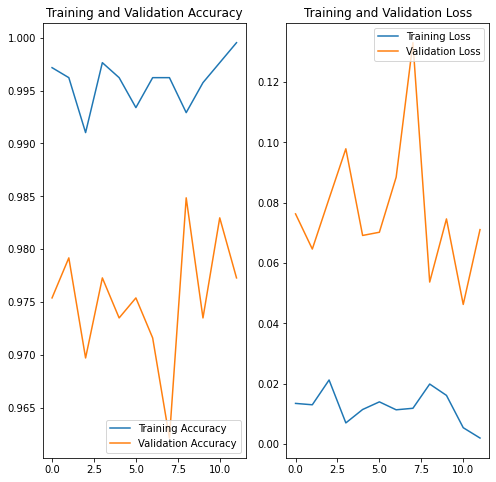

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
"""
1.YOU SHARED->FINE
2.YOU SHARED VIDEO 1>FAILED
3.YOU SHARED VIDEO 2->PASSED
"""


'\n1.YOU SHARED->FINE\n2.YOU SHARED VIDEO 1>FAILED\n3.YOU SHARED VIDEO 2->PASSED\n'

## Predict on MODEL-1-FINE

In [ ]:
#MULTIPLE IMAGES TESTING AT ONCE

In [22]:
import os
import tensorflow as tf

# Create a model with the same architecture as the original model
#model = tf.keras.Sequential([...])  # Replace with your model architecture

# Load the weights from a saved checkpoint file
model.load_weights(r'MODEL_1OP.hd5')

# Folder path containing the images
#test dataset 1(pranav dataset) and test dataset 2(youtube video 1) and test dataset 3(youtube video 2 with dlib)
folder_path = r'D:\\UNBC_VID\\folder'
# Iterate over each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load and preprocess the image
        image_path = os.path.join(folder_path, filename)
        img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Make predictions on the image
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Print the prediction results
        print("Image:", filename)
        print("Predicted class:", class_names[np.argmax(score)])
        print("Confidence:", 100 * np.max(score))
        print("----------------------------------")


1/1 [==============================] - 0s 106ms/step
Image: 1.jpg
Predicted class: InitialPain
Confidence: 51.623499393463135
----------------------------------
1/1 [==============================] - 0s 26ms/step
Image: 10.jpg
Predicted class: InitialPain
Confidence: 78.2304584980011
----------------------------------
1/1 [==============================] - 0s 27ms/step
Image: 100.jpg
Predicted class: InitialPain
Confidence: 99.96989965438843
----------------------------------
1/1 [==============================] - 0s 28ms/step
Image: 1000.jpg
Predicted class: InitialPain
Confidence: 99.9535083770752
----------------------------------
1/1 [==============================] - 0s 34ms/step
Image: 1001.jpg
Predicted class: IntensePain
Confidence: 79.99447584152222
----------------------------------
1/1 [==============================] - 0s 29ms/step
Image: 1002.jpg
Predicted class: InitialPain
Confidence: 99.95310306549072
----------------------------------
1/1 [=============================

In [27]:
img_height = 224
img_width = 224

In [29]:
image_path = '2cropped.jpg'
img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Make predictions on the image
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

        # Print the prediction results
print("Image:", image_path)
print("Predicted class:", class_names[np.argmax(score)])
print("Confidence:", 100 * np.max(score))
print("----------------------------------")


1/1 [==============================] - 0s 265ms/step
Image: 2cropped.jpg


NameError: name 'class_names' is not defined

In [21]:
#FINAL BUT ONE CELL

In [ ]:
#VGG CODE

In [26]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 10

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation datasets
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = train_datagen.flow_from_directory(train_folder,
                                                         target_size=input_shape[:2],
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False)

# Load the DenseNet model without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the DenseNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

# Save the model
model.save(r'MODEL_DENSENET_NEW.hd5')

print("Model saved successfully.")



Found 2101 images belonging to 3 classes.
Found 2101 images belonging to 3 classes.
Epoch 1/10
65/65 [==============================] - 307s 5s/step - loss: 0.9424 - accuracy: 0.5515 - val_loss: 0.7570 - val_accuracy: 0.6793
Epoch 2/10
65/65 [==============================] - 325s 5s/step - loss: 0.6091 - accuracy: 0.7564 - val_loss: 0.5370 - val_accuracy: 0.7937
Epoch 3/10
65/65 [==============================] - 350s 5s/step - loss: 0.5563 - accuracy: 0.7728 - val_loss: 0.5314 - val_accuracy: 0.7856
Epoch 4/10
65/65 [==============================] - 363s 6s/step - loss: 0.4833 - accuracy: 0.8081 - val_loss: 0.4678 - val_accuracy: 0.8154
Epoch 5/10
65/65 [==============================] - 328s 5s/step - loss: 0.4245 - accuracy: 0.8308 - val_loss: 0.3474 - val_accuracy: 0.8813
Epoch 6/10
65/65 [==============================] - 322s 5s/step - loss: 0.3966 - accuracy: 0.8395 - val_loss: 0.3575 - val_accuracy: 0.8683
Epoch 7/10
65/65 [==============================] - 329s 5s/step - los

INFO:tensorflow:Assets written to: MODEL_DENSENET_NEW.hd5\assets


INFO:tensorflow:Assets written to: MODEL_DENSENET_NEW.hd5\assets


Model saved successfully.


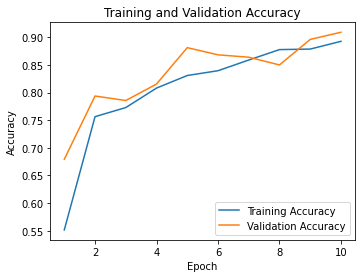

In [27]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


In [28]:
import os
import numpy as np
import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.models import load_model

# Path to the folder containing the images to predict
predict_folder = r'D:\\UNBC_VID\\folder'

# Load the saved model
model = load_model(r'MODEL_DENSENET_NEW.hd5')

# Parameters
input_shape = (224, 224)  # Input shape expected by the model

# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Get a list of image file paths in the predict folder
image_files = [os.path.join(predict_folder, file) for file in os.listdir(predict_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Iterate over the image files and make predictions
for image_file in image_files:
    # Preprocess the image
    image = preprocess_image(image_file, target_size=input_shape)
    
    # Make a prediction
    predictions = model.predict(image)
    class_indices = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # Get the class label and confidence score
    class_label = train_generator.class_indices
    class_name = list(class_label.keys())[list(class_label.values()).index(class_indices[0])]
    confidence_score = confidence_scores[0]
    
    # Print the prediction result
    print(f"Image: {image_file}")
    print(f"Predicted Class: {class_name}")
    print(f"Confidence Score: {confidence_score}")
    print("------------------------")


1/1 [==============================] - 2s 2s/step
Image: D:\\UNBC_VID\\folder\1.jpg
Predicted Class: IntensePain
Confidence Score: 0.9937885403633118
------------------------
1/1 [==============================] - 0s 254ms/step
Image: D:\\UNBC_VID\\folder\10.jpg
Predicted Class: IntensePain
Confidence Score: 0.9861370325088501
------------------------
1/1 [==============================] - 0s 246ms/step
Image: D:\\UNBC_VID\\folder\100.jpg
Predicted Class: NoPain
Confidence Score: 0.9776847958564758
------------------------
1/1 [==============================] - 0s 250ms/step
Image: D:\\UNBC_VID\\folder\1000.jpg
Predicted Class: NoPain
Confidence Score: 0.956627368927002
------------------------
1/1 [==============================] - 0s 241ms/step
Image: D:\\UNBC_VID\\folder\1001.jpg
Predicted Class: NoPain
Confidence Score: 0.6849343180656433
------------------------
1/1 [==============================] - 0s 253ms/step
Image: D:\\UNBC_VID\\folder\1002.jpg
Predicted Class: NoPain
Confid

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 15

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation datasets
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = train_datagen.flow_from_directory(train_folder,
                                                         target_size=input_shape[:2],
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False)

# Load the DenseNet model without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the DenseNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

# Save the model
model.save(r'DENSENET_15.hd5')

print("Model saved successfully.")

Found 2270 images belonging to 3 classes.
Found 2270 images belonging to 3 classes.
Epoch 1/15
70/70 [==============================] - 322s 5s/step - loss: 0.8216 - accuracy: 0.6336 - val_loss: 0.5951 - val_accuracy: 0.7540
Epoch 2/15
70/70 [==============================] - 318s 5s/step - loss: 0.5534 - accuracy: 0.7735 - val_loss: 0.4476 - val_accuracy: 0.8393
Epoch 3/15
70/70 [==============================] - 319s 5s/step - loss: 0.4402 - accuracy: 0.8405 - val_loss: 0.4471 - val_accuracy: 0.8156
Epoch 4/15
70/70 [==============================] - 324s 5s/step - loss: 0.4007 - accuracy: 0.8400 - val_loss: 0.3550 - val_accuracy: 0.8737
Epoch 5/15
70/70 [==============================] - 322s 5s/step - loss: 0.3782 - accuracy: 0.8503 - val_loss: 0.3250 - val_accuracy: 0.8750
Epoch 6/15
70/70 [==============================] - 323s 5s/step - loss: 0.3484 - accuracy: 0.8651 - val_loss: 0.6185 - val_accuracy: 0.7116
Epoch 7/15
70/70 [==============================] - 326s 5s/step - los

INFO:tensorflow:Assets written to: DENSENET_15.hd5\assets


INFO:tensorflow:Assets written to: DENSENET_15.hd5\assets


Model saved successfully.


In [ ]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [11]:
import os
import numpy as np
import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.models import load_model

# Path to the folder containing the images to predict
predict_folder = r'D:\\UNBC_VID\\folder'

# Load the saved model
model = load_model(r'DENSENET_15.hd5')

# Parameters
input_shape = (224, 224)  # Input shape expected by the model

# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Get a list of image file paths in the predict folder
image_files = [os.path.join(predict_folder, file) for file in os.listdir(predict_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Iterate over the image files and make predictions
for image_file in image_files:
    # Preprocess the image
    image = preprocess_image(image_file, target_size=input_shape)
    
    # Make a prediction
    predictions = model.predict(image)
    class_indices = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # Get the class label and confidence score
    class_label = train_generator.class_indices
    class_name = list(class_label.keys())[list(class_label.values()).index(class_indices[0])]
    confidence_score = confidence_scores[0]
    
    # Print the prediction result
    print(f"Image: {image_file}")
    print(f"Predicted Class: {class_name}")
    print(f"Confidence Score: {confidence_score}")
    print("------------------------")


1/1 [==============================] - 2s 2s/step
Image: D:\\UNBC_VID\\folder\1.jpg
Predicted Class: IntensePain
Confidence Score: 0.8714213967323303
------------------------
1/1 [==============================] - 0s 189ms/step
Image: D:\\UNBC_VID\\folder\10.jpg
Predicted Class: IntensePain
Confidence Score: 0.9386566281318665
------------------------
1/1 [==============================] - 0s 190ms/step
Image: D:\\UNBC_VID\\folder\100.jpg
Predicted Class: InitialPain
Confidence Score: 0.6613673567771912
------------------------
1/1 [==============================] - 0s 182ms/step
Image: D:\\UNBC_VID\\folder\1000.jpg
Predicted Class: IntensePain
Confidence Score: 0.3972082734107971
------------------------
1/1 [==============================] - 0s 191ms/step
Image: D:\\UNBC_VID\\folder\1001.jpg
Predicted Class: InitialPain
Confidence Score: 0.5725317597389221
------------------------
1/1 [==============================] - 0s 191ms/step
Image: D:\\UNBC_VID\\folder\1002.jpg
Predicted Clas

In [13]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 20

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation datasets
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = train_datagen.flow_from_directory(train_folder,
                                                         target_size=input_shape[:2],
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False)

# Load the DenseNet model without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the DenseNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False



Found 2270 images belonging to 3 classes.
Found 2270 images belonging to 3 classes.


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(),'accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

# Save the model
model.save(r'DENSENET_20.hd5')

print("Model saved successfully.")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_val_true = validation_generator.classes
y_val_pred = model.predict(validation_generator)
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred[:, 1])  # Assuming binary classification, adjust index if needed
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Also Converting to hsv and face detection

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.models import load_model

# Path to the folder containing the images to predict
predict_folder = 'D:\\UNBC_VID\\folder'

# Load the saved model
model = load_model(r'MODEL_DENSENET_NEW.hd5')

# Parameters
input_shape = (224, 224)  # Input shape expected by the model




In [3]:
# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

In [ ]:
# Iterate over the image files and make predictions
for file in os.listdir(predict_folder):
    # Preprocess the image
    image_file = os.path.join(predict_folder,file)
    # print(image_file)
    img = cv2.imread(image_file)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)

    # Loop through all detected faces and crop them
    for (x,y,w,h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 3)
        # Crop the face region from the image
        face_crop = img[y:y+h, x:x+w]


    image = preprocess_image(face_crop, target_size=input_shape)
    
    # Make a prediction
    predictions = model.predict(image)
    class_indices = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # Get the class label and confidence score
    class_label = train_generator.class_indices
    class_name = list(class_label.keys())[list(class_label.values()).index(class_indices[0])]
    confidence_score = confidence_scores[0]
    
    # Print the prediction result
    print(f"Image: {image_file}")
    print(f"Predicted Class: {class_name}")
    print(f"Confidence Score: {confidence_score}")
    print("------------------------")


In [ ]:
#plotting we can remove above code

In [33]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64
epochs = 40

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Load the VGGNet model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs)

# Save the model
model.save(r'MODEL_VGG_40.hd5')

print("Model saved successfully.")



Found 2101 images belonging to 3 classes.
Epoch 1/40


: 

: 

In [17]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_acc']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


KeyError: 'val_acc'

In [ ]:
#SINGLE IMAGE TESTING

In [37]:
import os
import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# Path to the folder containing the trained model
model_path = r'MODEL_VGG_15.hd5'

# Path to the single image for prediction
image_path = r'"D:\\UNBC_VID\\folder\\1.jpg"'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and preprocess the single image
image = load_img(image_path, target_size=input_shape[:2])
image_array = img_to_array(image)
image_array = preprocess_input(image_array)
image_array = tf.expand_dims(image_array, axis=0)

# Make the prediction
predictions = model.predict(image_array)
predicted_class_index = tf.argmax(predictions, axis=1)[0]

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Print the predicted class label
predicted_class_label = class_labels[predicted_class_index]
print(f'Predicted Class: {predicted_class_label}')


1/1 [==============================] - 0s 297ms/step
Predicted Class: IntensePain


In [18]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 15

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Load the VGGNet model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs)

# Save the model
model.save(r'VGG.hd5')

print("Model saved successfully.")



Found 2270 images belonging to 3 classes.
Epoch 1/15
70/70 [==============================] - 1215s 17s/step - loss: 1.0761 - accuracy: 0.4187
Epoch 2/15
70/70 [==============================] - 1203s 17s/step - loss: 0.9507 - accuracy: 0.5634
Epoch 3/15
70/70 [==============================] - 1109s 16s/step - loss: 0.8765 - accuracy: 0.6059
Epoch 4/15
70/70 [==============================] - 1097s 16s/step - loss: 0.8065 - accuracy: 0.6470
Epoch 5/15
70/70 [==============================] - 1112s 16s/step - loss: 0.7541 - accuracy: 0.6716
Epoch 6/15
70/70 [==============================] - 1148s 16s/step - loss: 0.7649 - accuracy: 0.6568
Epoch 7/15
70/70 [==============================] - 1160s 17s/step - loss: 0.6967 - accuracy: 0.7163
Epoch 8/15
70/70 [==============================] - 1165s 17s/step - loss: 0.6812 - accuracy: 0.7055
Epoch 9/15
70/70 [==============================] - 1164s 17s/step - loss: 0.6500 - accuracy: 0.7256
Epoch 10/15
70/70 [==============================

INFO:tensorflow:Assets written to: VGG.hd5\assets


INFO:tensorflow:Assets written to: VGG.hd5\assets


Model saved successfully.


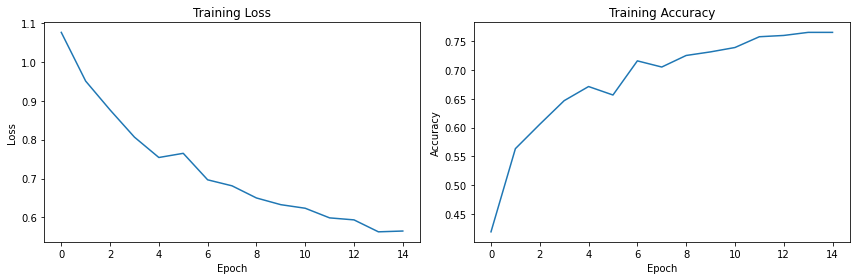

In [22]:
# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


**VGG 16 COMPARISON**

VGG 40 EPOCHS RGB

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64
epochs = 40

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Load the VGGNet model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs)

# Save the model
model.save(r'VGG40.hd5')

print("Model saved successfully.")



Found 2270 images belonging to 3 classes.
Epoch 1/40
35/35 [==============================] - 314s 9s/step - loss: 1.0748 - accuracy: 0.4189
Epoch 2/40
35/35 [==============================] - 363s 11s/step - loss: 0.9887 - accuracy: 0.5281
Epoch 3/40
35/35 [==============================] - 353s 10s/step - loss: 0.9191 - accuracy: 0.6106
Epoch 4/40
35/35 [==============================] - 361s 10s/step - loss: 0.8593 - accuracy: 0.6360
Epoch 5/40
35/35 [==============================] - 364s 10s/step - loss: 0.8192 - accuracy: 0.6500
Epoch 6/40
35/35 [==============================] - 350s 10s/step - loss: 0.7926 - accuracy: 0.6636
Epoch 7/40
35/35 [==============================] - 345s 10s/step - loss: 0.7525 - accuracy: 0.6936
Epoch 8/40
35/35 [==============================] - 348s 10s/step - loss: 0.7227 - accuracy: 0.7090
Epoch 9/40
35/35 [==============================] - 347s 10s/step - loss: 0.7041 - accuracy: 0.7144
Epoch 10/40
35/35 [==============================] - 356s 1

INFO:tensorflow:Assets written to: VGG40.hd5\assets


INFO:tensorflow:Assets written to: VGG40.hd5\assets


Model saved successfully.


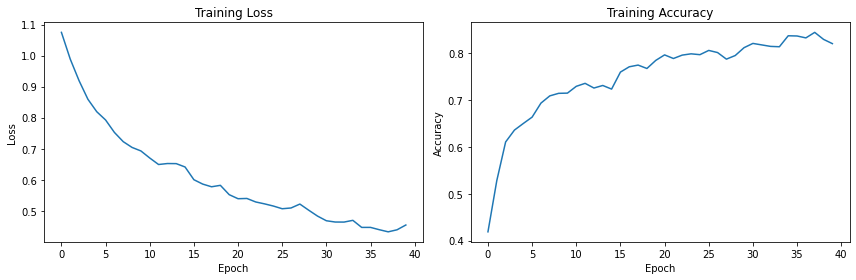

In [2]:
# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


Single Image Testing

In [26]:
import os
import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# Path to the folder containing the trained model
model_path = r'VGG40.hd5'

# Path to the single image for prediction
image_path = r'ak064t1aaaff137.png'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and preprocess the single image
image = load_img(image_path, target_size=input_shape[:2])
image_array = img_to_array(image)
image_array = preprocess_input(image_array)
image_array = tf.expand_dims(image_array, axis=0)

# Make the prediction
predictions = model.predict(image_array)
predicted_class_index = tf.argmax(predictions, axis=1)[0]

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Print the predicted class label
predicted_class_label = class_labels[predicted_class_index]
print(f'Predicted Class: {predicted_class_label}')


1/1 [==============================] - 0s 433ms/step
Predicted Class: NoPain


**VGG 40 EPOCHS HSV**

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_HSV'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64
epochs = 40

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(train_folder,
                                                         target_size=input_shape[:2],
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False)

# Load the VGGNet model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size
                    )

# Save the model
model.save(r'VGG40_HSV.hd5')

print("Model saved successfully.")



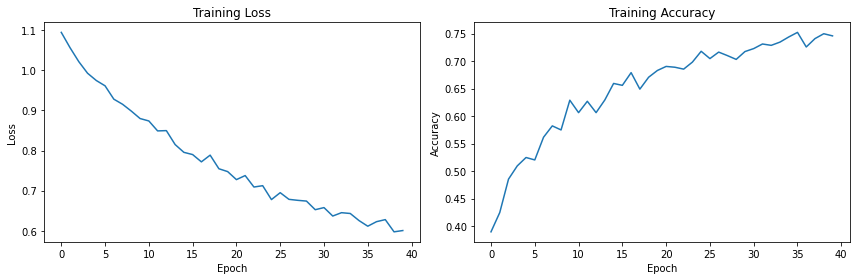

In [ ]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


In [14]:
import os
import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import cv2

# Path to the folder containing the trained model
model_path = r'VGG40_HSV.hd5'

# Path to the single image for prediction

img = cv2.imread('2.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
cv2.imwrite('2_hsv.jpg',hsv)
image_path = r'2_hsv.jpg'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and preprocess the single image
image = load_img(image_path, target_size=input_shape[:2])
image_array = img_to_array(image)
image_array = preprocess_input(image_array)
image_array = tf.expand_dims(image_array, axis=0)

# Make the prediction
predictions = model.predict(image_array)
predicted_class_index = tf.argmax(predictions, axis=1)[0]

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Print the predicted class label
predicted_class_label = class_labels[predicted_class_index]
print(f'Predicted Class: {predicted_class_label}')


1/1 [==============================] - 0s 295ms/step
Predicted Class: IntensePain


In [18]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 40

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# validation_generator = train_datagen.flow_from_directory(train_folder,
#                                                          target_size=input_shape[:2],
#                                                          batch_size=batch_size,
#                                                          class_mode='categorical',
#                                                          shuffle=False)

# Load the VGGNet model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size
                    )

# Save the model
model.save(r'VGG40_1.hd5')

print("Model saved successfully.")



Found 2270 images belonging to 3 classes.
Found 2270 images belonging to 3 classes.
Epoch 1/40
70/70 [==============================] - 702s 10s/step - loss: 1.0783 - accuracy: 0.3901 - val_loss: 0.9971 - val_accuracy: 0.5281
Epoch 2/40
70/70 [==============================] - 835s 12s/step - loss: 0.9815 - accuracy: 0.5299 - val_loss: 0.9653 - val_accuracy: 0.4862
Epoch 3/40
70/70 [==============================] - 826s 12s/step - loss: 0.9009 - accuracy: 0.5889 - val_loss: 0.8517 - val_accuracy: 0.6170
Epoch 4/40
70/70 [==============================] - 830s 12s/step - loss: 0.8256 - accuracy: 0.6497 - val_loss: 0.8244 - val_accuracy: 0.6080
Epoch 5/40
70/70 [==============================] - 823s 12s/step - loss: 0.7761 - accuracy: 0.6644 - val_loss: 0.7594 - val_accuracy: 0.6661
Epoch 6/40
70/70 [==============================] - 828s 12s/step - loss: 0.7362 - accuracy: 0.6859 - val_loss: 0.7297 - val_accuracy: 0.7112
Epoch 7/40
70/70 [==============================] - 833s 12s/ste

INFO:tensorflow:Assets written to: VGG40_1.hd5\assets


INFO:tensorflow:Assets written to: VGG40_1.hd5\assets


Model saved successfully.


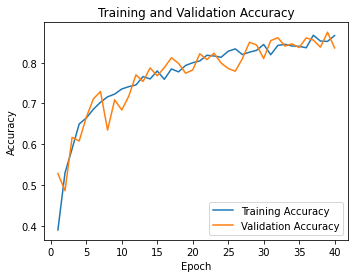

In [19]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
from keras.optimizers import SGD
from keras.layers import Input, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K
from sklearn.metrics import log_loss
# from custom_layers.scale_layer import Scale
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split   

import os

import numpy as np
from keras.utils import np_utils
from keras import backend as K
from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file

In [17]:
from keras.callbacks import ModelCheckpoint
import random
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import cv2
from keras.utils import img_to_array

In [18]:
def load_data():
  data=[]
  labels=[]
  random.seed(42)
  imagePaths = sorted(list(os.listdir("D:\\UNBC_DATASET\\CROPPED_RGB")))
  random.shuffle(imagePaths)
  print(imagePaths)

  for img in imagePaths:
    path=sorted(list(os.listdir("D:\\UNBC_DATASET\\CROPPED_RGB/"+img)))
    for i in path:
        image = cv2.imread("D:\\UNBC_DATASET\\CROPPED_RGB/"+img+'/'+i)
        image = cv2.resize(image, (224,224))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)
  data = np.array(data, dtype="float32") / 255.0
  labels = np.array(labels)
  mlb = preprocessing.LabelBinarizer()
  labels = mlb.fit_transform(labels)
  #print(labels[0])

  (xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.25,random_state=42)
  #print(xtrain.shape, xtest.shape)
  return xtrain, ytrain, xtest, ytest

In [19]:
if __name__ == '__main__':

    # Example to fine-tune on 3000 samples from Cifar10

    img_rows, img_cols = 224, 224 # Resolution of inputs
    channel = 3
    num_classes =3
    batch_size = 64 
    nb_epoch = 40


    X_train, Y_train, X_valid, Y_valid = load_data()

    # Load our model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    filepath="bestmodel.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Start Fine-tuning
    history=model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              callbacks=callbacks_list,
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score
    score = log_loss(Y_valid, predictions_valid)
    model.save(r'New.hd5')
    print("Model Saved")

['IntensePain', 'InitialPain', 'NoPain']
Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.7573WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 282s 11s/step - loss: 0.5987 - accuracy: 0.7573 - val_loss: 0.4808 - val_accuracy: 0.8028
Epoch 2/40
27/27 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8267WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 348s 13s/step - loss: 0.4589 - accuracy: 0.8267 - val_loss: 0.4401 - val_accuracy: 0.8433
Epoch 3/40
27/27 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8467 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 368s 14s/step - loss: 0.4188 - accuracy: 0.8467 - val_loss: 0.4084 - val_accuracy: 0.8768
Epoch 4/40
27/27 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8713 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 371s 14s/step - loss: 0.4008 - accuracy: 0.8713 - val_loss: 0.3976 - val_accuracy: 0.8697
Epoch 5/40
27/27 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8913 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 372s 14s/step - loss: 0.3698 - accuracy: 0.8913 - val_loss: 0.3997 - val_accuracy: 0.8627
Epoch 6/40
27/27 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.9060 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 367s 14s/step - loss: 0.3455 - accuracy: 0.9060 - val_loss: 0.3604 - val_accuracy: 0.9032
Epoch 7/40
27/27 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8984WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 348s 13s/step - loss: 0.3396 - accuracy: 0.8984 - val_loss: 0.4051 - val_accuracy: 0.8768
Epoch 8/40
27/27 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.9019WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 345s 13s/step - loss: 0.3365 - accuracy: 0.9019 - val_loss: 0.3533 - val_accuracy: 0.8662
Epoch 9/40
27/27 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.9001WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 343s 13s/step - loss: 0.3147 - accuracy: 0.9001 - val_loss: 0.3463 - val_accuracy: 0.8961
Epoch 10/40
27/27 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.9048WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 342s 13s/step - loss: 0.3214 - accuracy: 0.9048 - val_loss: 0.3137 - val_accuracy: 0.9208
Epoch 11/40
27/27 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.9148WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 351s 13s/step - loss: 0.2984 - accuracy: 0.9148 - val_loss: 0.3080 - val_accuracy: 0.9173
Epoch 12/40
27/27 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9236 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 363s 14s/step - loss: 0.2740 - accuracy: 0.9236 - val_loss: 0.3172 - val_accuracy: 0.9102
Epoch 13/40
27/27 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9183WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 346s 13s/step - loss: 0.2752 - accuracy: 0.9183 - val_loss: 0.3279 - val_accuracy: 0.9032
Epoch 14/40
27/27 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9242WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 336s 12s/step - loss: 0.2542 - accuracy: 0.9242 - val_loss: 0.3010 - val_accuracy: 0.9085
Epoch 15/40
27/27 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9354WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 335s 13s/step - loss: 0.2495 - accuracy: 0.9354 - val_loss: 0.2772 - val_accuracy: 0.9261
Epoch 16/40
27/27 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9301WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 342s 13s/step - loss: 0.2399 - accuracy: 0.9301 - val_loss: 0.2855 - val_accuracy: 0.9049
Epoch 17/40
27/27 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9348WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 352s 13s/step - loss: 0.2325 - accuracy: 0.9348 - val_loss: 0.2846 - val_accuracy: 0.9208
Epoch 18/40
27/27 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9371WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 355s 13s/step - loss: 0.2241 - accuracy: 0.9371 - val_loss: 0.2595 - val_accuracy: 0.9296
Epoch 19/40
27/27 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9412 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 355s 13s/step - loss: 0.2138 - accuracy: 0.9412 - val_loss: 0.2526 - val_accuracy: 0.9313
Epoch 20/40
27/27 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9401 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 355s 13s/step - loss: 0.2120 - accuracy: 0.9401 - val_loss: 0.2796 - val_accuracy: 0.9173
Epoch 21/40
27/27 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 349s 13s/step - loss: 0.2210 - accuracy: 0.9318 - val_loss: 0.2791 - val_accuracy: 0.9155
Epoch 22/40
27/27 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9371WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 354s 13s/step - loss: 0.2049 - accuracy: 0.9371 - val_loss: 0.2381 - val_accuracy: 0.9401
Epoch 23/40
27/27 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9459WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 351s 13s/step - loss: 0.1976 - accuracy: 0.9459 - val_loss: 0.2684 - val_accuracy: 0.9102
Epoch 24/40
27/27 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9354WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 354s 13s/step - loss: 0.1991 - accuracy: 0.9354 - val_loss: 0.2297 - val_accuracy: 0.9472
Epoch 25/40
27/27 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9389WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 354s 13s/step - loss: 0.1913 - accuracy: 0.9389 - val_loss: 0.2338 - val_accuracy: 0.9401
Epoch 26/40
27/27 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9471 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 351s 13s/step - loss: 0.1828 - accuracy: 0.9471 - val_loss: 0.2231 - val_accuracy: 0.9489
Epoch 27/40
27/27 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9489 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 353s 13s/step - loss: 0.1745 - accuracy: 0.9489 - val_loss: 0.2362 - val_accuracy: 0.9349
Epoch 28/40
27/27 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9506 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 357s 13s/step - loss: 0.1730 - accuracy: 0.9506 - val_loss: 0.2151 - val_accuracy: 0.9507
Epoch 29/40
27/27 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9512 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 353s 13s/step - loss: 0.1696 - accuracy: 0.9512 - val_loss: 0.2197 - val_accuracy: 0.9489
Epoch 30/40
27/27 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9518WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 354s 13s/step - loss: 0.1649 - accuracy: 0.9518 - val_loss: 0.2568 - val_accuracy: 0.9085
Epoch 31/40
27/27 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9501WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 350s 13s/step - loss: 0.1577 - accuracy: 0.9501 - val_loss: 0.2097 - val_accuracy: 0.9437
Epoch 32/40
27/27 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9530WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 355s 13s/step - loss: 0.1570 - accuracy: 0.9530 - val_loss: 0.2145 - val_accuracy: 0.9454
Epoch 33/40
27/27 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9512WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 353s 13s/step - loss: 0.1589 - accuracy: 0.9512 - val_loss: 0.2008 - val_accuracy: 0.9525
Epoch 34/40
27/27 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9518 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 356s 13s/step - loss: 0.1548 - accuracy: 0.9518 - val_loss: 0.1981 - val_accuracy: 0.9542
Epoch 35/40
27/27 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9542 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 357s 13s/step - loss: 0.1566 - accuracy: 0.9542 - val_loss: 0.2137 - val_accuracy: 0.9454
Epoch 36/40
27/27 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9483 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 354s 13s/step - loss: 0.1567 - accuracy: 0.9483 - val_loss: 0.1988 - val_accuracy: 0.9472
Epoch 37/40
27/27 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9542 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 356s 13s/step - loss: 0.1395 - accuracy: 0.9542 - val_loss: 0.1931 - val_accuracy: 0.9454
Epoch 38/40
27/27 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9624WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 352s 13s/step - loss: 0.1423 - accuracy: 0.9624 - val_loss: 0.2153 - val_accuracy: 0.9507
Epoch 39/40
27/27 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9583 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


27/27 [==============================] - 358s 13s/step - loss: 0.1441 - accuracy: 0.9583 - val_loss: 0.1914 - val_accuracy: 0.9454
Epoch 40/40
27/27 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9595WARNING:tensorflow:Can save best model only with val_acc available, skipping.


9/9 [==============================] - 90s 10s/step


INFO:tensorflow:Assets written to: New.hd5\assets


INFO:tensorflow:Assets written to: New.hd5\assets


Model Saved


In [20]:
print(score)

0.2029486046561635


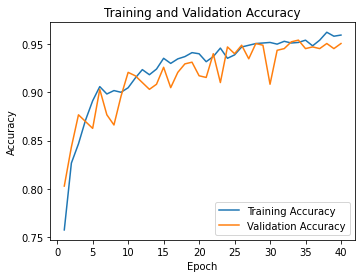

In [21]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

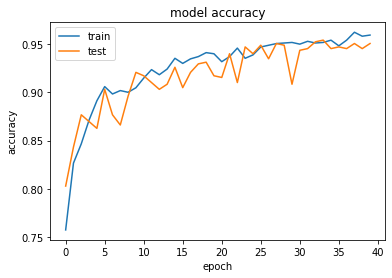

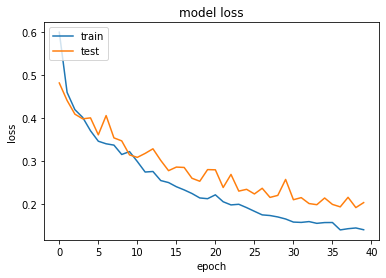

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
xtest=X_valid
ytest=Y_valid
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

In [23]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64
epochs = 40

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_folder,
                                                         target_size=input_shape[:2],
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False,
                                                         subset='validation')

# Load the VGGNet model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size
                    )

# Save the model
model.save(r'VGG40_2.hd5')

print("Model saved successfully.")



Found 1817 images belonging to 3 classes.
Found 453 images belonging to 3 classes.
Epoch 1/40
28/28 [==============================] - 255s 9s/step - loss: 1.0950 - accuracy: 0.4284 - val_loss: 1.0525 - val_accuracy: 0.5960
Epoch 2/40
28/28 [==============================] - 328s 12s/step - loss: 0.9776 - accuracy: 0.5819 - val_loss: 1.0297 - val_accuracy: 0.4621
Epoch 3/40
28/28 [==============================] - 346s 13s/step - loss: 0.8808 - accuracy: 0.6515 - val_loss: 1.0079 - val_accuracy: 0.4710
Epoch 4/40
28/28 [==============================] - 361s 13s/step - loss: 0.7961 - accuracy: 0.7085 - val_loss: 1.0103 - val_accuracy: 0.4665
Epoch 5/40
28/28 [==============================] - 354s 13s/step - loss: 0.7335 - accuracy: 0.7262 - val_loss: 0.9996 - val_accuracy: 0.4710
Epoch 6/40
28/28 [==============================] - 357s 13s/step - loss: 0.6982 - accuracy: 0.7262 - val_loss: 0.9864 - val_accuracy: 0.5179
Epoch 7/40
28/28 [==============================] - 371s 13s/step 

INFO:tensorflow:Assets written to: VGG40_2.hd5\assets


INFO:tensorflow:Assets written to: VGG40_2.hd5\assets


Model saved successfully.


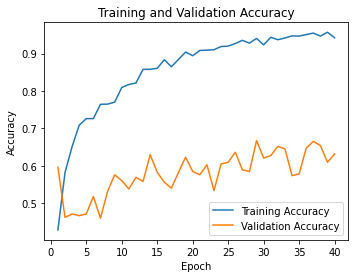

In [24]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [27]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Path to the folder containing the training images
train_folder = r'D:\\UNBC_DATASET\\CROPPED_RGB'

# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64
epochs = 40

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Load the training dataset
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_folder,
                                                         target_size=input_shape[:2],
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False,
                                                         subset='validation')

# Load the VGGNet model without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the VGGNet model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size
                    )

# Save the model
model.save(r'DenseNet_2_RGB.hd5')

print("Model saved successfully.")



Found 1817 images belonging to 3 classes.
Found 453 images belonging to 3 classes.
Epoch 1/40
28/28 [==============================] - 153s 5s/step - loss: 0.9420 - accuracy: 0.5859 - val_loss: 1.0211 - val_accuracy: 0.5402
Epoch 2/40
28/28 [==============================] - 169s 6s/step - loss: 0.5195 - accuracy: 0.8135 - val_loss: 0.8678 - val_accuracy: 0.5603
Epoch 3/40
28/28 [==============================] - 161s 6s/step - loss: 0.3825 - accuracy: 0.8789 - val_loss: 0.7858 - val_accuracy: 0.6339
Epoch 4/40
28/28 [==============================] - 169s 6s/step - loss: 0.2940 - accuracy: 0.9070 - val_loss: 0.7966 - val_accuracy: 0.6406
Epoch 5/40
28/28 [==============================] - 177s 6s/step - loss: 0.2531 - accuracy: 0.9241 - val_loss: 0.8353 - val_accuracy: 0.6183
Epoch 6/40
28/28 [==============================] - 165s 6s/step - loss: 0.2108 - accuracy: 0.9418 - val_loss: 0.9490 - val_accuracy: 0.6094
Epoch 7/40
28/28 [==============================] - 165s 6s/step - loss

INFO:tensorflow:Assets written to: DenseNet_2_RGB.hd5\assets


INFO:tensorflow:Assets written to: DenseNet_2_RGB.hd5\assets


Model saved successfully.


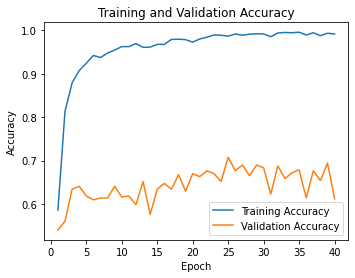

In [28]:
# Plot accuracy and validation accuracy curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()